<a href="https://www.kaggle.com/code/pronoydeb/convnext-model?scriptVersionId=258951672" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <span style="color:coral"> <center> ConvNeXt with tensorflow</center> </span>

# <span >Notebook Overview</span>

* In this notebook I have implemented `ConvNext tiny` model from the research paper titled as [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545) using tensorflow.

* The code in this notebook is reusable and can be reused with any dataset of your choice.

* In this notebook I will train `ConvNext tiny` model from scratch on CIFAR-10 dataset.


In [13]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

# <span style="color:coral">Loading Data</span>

In [14]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to dataset
data_path = "/kaggle/input/severity-based-rice-disease-final/severity-based-rice-disease-final"

def safe_label(name: str):
    """Convert folder name into safe label"""
    return name.strip().replace(" ", "_").replace("-", "_")

def load_leaf_disease_dataset(dataset_path, img_size=(128, 128)):
    def load_subset(subset):
        images = []
        labels = []
        subset_path = os.path.join(dataset_path, subset)

        for disease_name in os.listdir(subset_path):
            disease_path = os.path.join(subset_path, disease_name)
            if os.path.isdir(disease_path):
                safe_name = safe_label(disease_name)  # <-- use safe name here
                for img_file in os.listdir(disease_path):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(disease_path, img_file)
                        try:
                            img = Image.open(img_path).convert("RGB")
                            img = img.resize(img_size)
                            images.append(np.array(img))
                            labels.append(safe_name)   # <-- append safe label
                        except Exception as e:
                            print(f"Error loading {img_path}: {e}")
        return np.array(images), np.array(labels)

    # Load train, validation, and test separately
    x_train, y_train = load_subset("train")
    x_val, y_val = load_subset("validation")
    x_test, y_test = load_subset("test")

    # Encode labels
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_val = le.transform(y_val)
    y_test = le.transform(y_test)

    return (x_train, y_train), (x_val, y_val), (x_test, y_test), le.classes_

# Load data
(x_train, y_train), (x_val, y_val), (x_test, y_test), class_names = load_leaf_disease_dataset(data_path)

# Normalize images (0–1)
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

print(f"Classes detected: {class_names}")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

# -------------------------
# Data Augmentation (only for training)
# -------------------------
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Fit generator to training data
datagen.fit(x_train)

train_generator = datagen.flow(x_train, y_train, batch_size=32)
val_generator = (x_val, y_val)  # no augmentation for validation
test_generator = (x_test, y_test)  # no augmentation for test


Classes detected: ['Healthy' 'Mild_Bacterial_blight' 'Mild_Blast' 'Mild_Brownspot'
 'Mild_Tungro' 'Severe_Bacterial_blight' 'Severe_Blast' 'Severe_Brownspot'
 'Severe_Tungro']
x_train: (2402, 128, 128, 3), y_train: (2402,)
x_val: (424, 128, 128, 3), y_val: (424,)
x_test: (180, 128, 128, 3), y_test: (180,)


I will be using `tf.data` api which helps to build flexible and efficient input pipeline.
​
td.data allows us to do various tasks in memory efficient way such as :
​
* `map()` - maps a predefined function to dataset
* `shuffle()` - randomly shuffles the elements of a target 
* `batch()` - turns dataset into batches 
* `prefetch()` - prepares subsequent batches of data while other batches of data are being computed

In [15]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE=16
# convert images to float32 format and convert labels to int32
def preprocess (image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(label, tf.int32)
    return image, label

#Peform augmentations on training data
def augmentation(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40) # Add 8 pixels of padding
    image = tf.image.random_crop(image, size=[32, 32, 3]) # Random crop back to 32x32
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)
    return image, label


train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#applying transformations 
train_data = train_data.shuffle(1024) # shuffle the images
train_data = train_data.map(preprocess, num_parallel_calls=AUTO)# mapping our preprocess function to train_data 
train_data = train_data.map(augmentation, num_parallel_calls=AUTO)# mapping our augmentation funtion to train_data
train_data = train_data.batch(BATCH_SIZE) #Converting train_data to batches
train_data = train_data.prefetch(AUTO) # using prefetch which prepares subsequent batches of data while other batches are being computed.

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#applying transformations 
test_data = test_data.map(preprocess, num_parallel_calls=AUTO) # mapping our preprocess function test_data 
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(AUTO) # using prefetch which prepares subsequent batches of data while other batches are being computed.

# <center>ConvNeXt Block</center>

For implementing `ConvNeXt` block authors take inspiration from the `ResNext` architecture which use [grouped convolutions](https://paperswithcode.com/method/grouped-convolution#:~:text=A%20Grouped%20Convolution%20uses%20a,level%20and%20high%20level%20features.), for `ConvNeXt` block authors utlize the combination of [depthwise convolutions](https://paperswithcode.com/method/depthwise-convolution) and 1x1 [point-wise convolutions](https://paperswithcode.com/method/pointwise-convolution). Depthwise convolutions reduce the number of parameters and computation used in convolutional operations while increasing representational efficiency. Pointwise convolutions is a 1x1 convolution which projects the channels output by the depthwise convolution onto a new channel space
 
In this paper authors use a slightly modified [inverted bottle-neck](https://paperswithcode.com/method/inverted-residual-block) design given by:

1. A depthwise convolution, authors found out that `7x7 size` depthwise convolution gives better performance than that of other sizes. followed by a layer norm normalization layer as used in transformer architectures.

2. `Layer normalization` is used after the depthwise convolution instead of the Batch Normalization. As opposed to ResNet Block architecture ConvNeXt block only uses `layer norm` once in a residual block. 

> `Note:` In batchnorm, the mean and variance used for normalization are calculated across all elements in a batch, for each feature independently while in layernorm, they are calculated across the feature dimension, for each element and instance independently. 

3. A 1x1 `pointwise convolution` is used after LN.

4. A [GELU](https://paperswithcode.com/method/gelu) activation function is used after 1x1 pointwise convolutional layer. As opposed to multiple ReLU activations in ResNet residual block, ConvNext uses GELU activation function only once in a residual block.

5. Another 1x1 `pointwise convolution` is used.

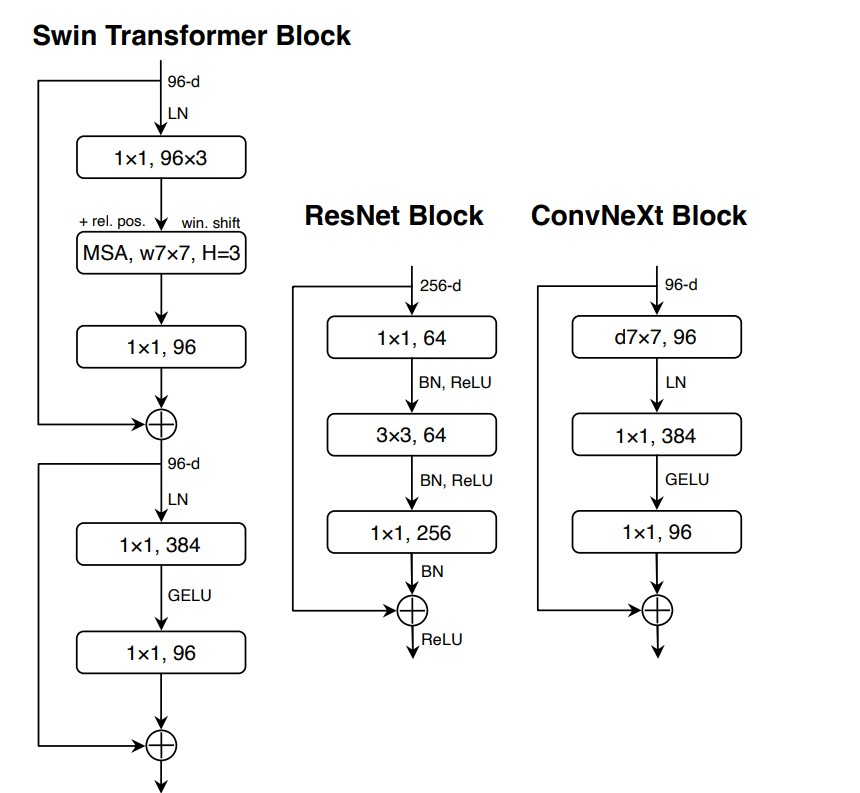

> Image source [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545) 

In [16]:
class ConvNext_Block(tf.keras.Model):
    
    """
    Implementing the ConvNeXt block for 
    
    Args:
        dim: No of input channels
        drop_path: stotchastic depth rate 
        layer_scale_init_value=1e-6
    
    Returns:
        A conv block
    """
    
    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6, **kwargs):
        super(ConvNext_Block, self).__init__(**kwargs)
        
        self.depthwise_convolution = layers.Conv2D(dim, kernel_size=7, padding="same", groups=dim )
        self.layer_normalization = layers.LayerNormalization(epsilon=1e-6)
        self.pointwise_convolution_1 = layers.Dense(4 * dim)
        self.GELU = layers.Activation("gelu")
        self.pointwise_convolution_2 = layers.Dense(dim)
        self.gamma = tf.Variable(layer_scale_init_value * tf.ones((dim,)))
        if drop_path>0.0:
            self.drop_path=(tfa.layers.StochasticDepth(drop_path))
        else:
            self.drop_path=layers.Activation("linear")
        

    def call(self, inputs):
        x = inputs
        x = self.depthwise_convolution(x)
        x = self.layer_normalization(x)
        x = self.pointwise_convolution_1(x)
        x = self.GELU(x)
        x = self.pointwise_convolution_2(x)
        x = self.gamma * x

        return inputs + self.drop_path(x)


# Patchify Stem 

For processing the input images, ConvNeXt utilizes patchify strategy of transformers by 4x4 convolutional layer with stride of 4 i.e it will have non overlapping patches.

In [17]:
def patchify_stem(dims):
    """
    Implements the stem block of ConvNeXt
    
    Args:
        Dims: List of feature dimensions at each stage.
    
    Returns:
        feature maps after patchify operation
    """
    stem = keras.Sequential(
        [layers.Conv2D(dims[0], kernel_size=4, strides=4),
        layers.LayerNormalization(epsilon=1e-6)],
        )
    return stem

# Spatial Downsampling

Similar to Resnets and Swin Transformer, ConvNext perform spatial downsampling with `2x2` conv layer having `stride` of **2**. Authors of the paper observed that adding Layer Normalization layer gives significantly good performance.



In [18]:
def spatial_downsampling(stem,dims,kernel_size,stride):
    """
    Implements Spatial Downsampling of ConvNeXt
    
    Args:
        Dims: List of feature dimensions at each stage.
        stem: Patchify stem output of images
        kernel_size: Downsampling kernel_size
        stride: Downsampling stride length
    Returns:
        Downsampled layers
    """

    ds_layers = []
    ds_layers.append(stem)
    for dim in dims[1:]:
        layer = keras.Sequential(
            [layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(dim, kernel_size=kernel_size, strides=stride),
            ]
        )
        ds_layers.append(layer)
        
    return ds_layers

# Convnext Stages
We will iteratively build the stages of ConvNeXt block by calling the ConvNext_Block function created earlier over the feature dimensions at each stage.

In [19]:
def ConvNext_Stages (dims,drop_path_rate,depths,layer_scale_init_value):
    """
    Creating stages each consiting of multiple residual blocks
    
    Args:
        dims: List of feature dimensions at each stage.
        drop_path_rate: Stochastic depth rate
        depths: Number of blocks at each stage
        layer_scale_init_value: Init value for Layer Scale
        
    """
    stages = []
    dropout_rates = [x for x in tf.linspace(0.0, drop_path_rate, sum(depths))]
    cur = 0
    for i in range(len(dims)):
        stage = keras.Sequential(
            [*[ConvNext_Block(dim=dims[i],drop_path=dropout_rates[cur + j],layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            ]
        )
        stages.append(stage)
        cur += depths[i]
    return stages

# Final ConvNeXt Model

In this implementaion I will be implementing the ConvNeXt-T having dimensions = (96, 192, 384, 768) and depths = (3, 3, 9, 3)

In [20]:
drop_path_rate=0.0
layer_scale_init_value=1e-6
dims=[1, 1, 1, 1]
depths=[3, 3, 9, 3]

In [21]:
inputs = layers.Input((32,32,3))
x = inputs

stem=patchify_stem(dims)

downsampling=spatial_downsampling(stem,dims,kernel_size=2,stride=2)

stages=ConvNext_Stages(dims,drop_path_rate,depths,layer_scale_init_value)

for i in range(len(stages)):
    x = downsampling[i](x)
    x = stages[i](x)

x = layers.GlobalAvgPool2D()(x)
x = layers.LayerNormalization(epsilon=1e-6)(x)

outputs = layers.Dense(10)(x)

ConvNeXt_model=keras.Model(inputs, outputs)

In [22]:
ConvNeXt_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 8, 8, 1)           51        
_________________________________________________________________
sequential_4 (Sequential)    (None, 8, 8, 1)           198       
_________________________________________________________________
sequential_1 (Sequential)    (None, 4, 4, 1)           7         
_________________________________________________________________
sequential_5 (Sequential)    (None, 4, 4, 1)           198       
_________________________________________________________________
sequential_2 (Sequential)    (None, 2, 2, 1)           7         
_________________________________________________________________
sequential_6 (Sequential)    (None, 2, 2, 1)           594   

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report

class MetricsLogger(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []
        
        for batch in self.validation_data:
            images, labels = batch
            preds = self.model.predict(images, verbose=0)
            preds = np.argmax(preds, axis=1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds)

        report = classification_report(y_true, y_pred, output_dict=False)
        print("\nValidation Classification Report:\n", report)


In [24]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [25]:
from tensorflow.keras import layers, models
import tensorflow as tf
import tensorflow_addons as tfa

# Define ConvNeXt with input_shape=(224, 224, 3)
def build_convnext_model(input_shape=(128, 128, 3), num_classes=len(class_names)):
    inputs = layers.Input(shape=input_shape)
    
    # Example ConvNeXt block (adjust architecture as needed)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.Activation("gelu")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)
    
    # Add more ConvNeXt blocks...
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes)(x)
    
    model = models.Model(inputs, outputs)
    return model

# Build model
ConvNeXt_model = build_convnext_model(input_shape=(128, 128, 3))

# Compile
ConvNeXt_model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train
metrics_logger = MetricsLogger(validation_data=test_data)

history = ConvNeXt_model.fit(train_generator,
          validation_data=val_generator,
          epochs=300)

Epoch 1/300
76/76 [==============================] - 19s 236ms/step - loss: 2.1318 - accuracy: 0.2406 - val_loss: 2.0016 - val_accuracy: 0.2146
Epoch 2/300
76/76 [==============================] - 18s 231ms/step - loss: 1.7788 - accuracy: 0.3585 - val_loss: 1.6653 - val_accuracy: 0.4410
Epoch 3/300
76/76 [==============================] - 18s 231ms/step - loss: 1.5796 - accuracy: 0.4550 - val_loss: 1.4550 - val_accuracy: 0.4976
Epoch 4/300
76/76 [==============================] - 18s 231ms/step - loss: 1.5347 - accuracy: 0.4617 - val_loss: 1.4606 - val_accuracy: 0.5024
Epoch 5/300
76/76 [==============================] - 17s 227ms/step - loss: 1.4735 - accuracy: 0.4833 - val_loss: 1.4366 - val_accuracy: 0.5142
Epoch 6/300
76/76 [==============================] - 18s 229ms/step - loss: 1.4307 - accuracy: 0.5158 - val_loss: 1.3159 - val_accuracy: 0.5590
Epoch 7/300
76/76 [==============================] - 18s 231ms/step - loss: 1.4338 - accuracy: 0.5125 - val_loss: 1.3395 - val_accuracy:

In [26]:
# After training
y_pred = []
y_true = []

for images, labels in test_data:
    preds = ConvNeXt_model.predict(images, verbose=0)
    preds = np.argmax(preds, axis=1)
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


                         precision    recall  f1-score   support

                Healthy       1.00      1.00      1.00        20
  Mild_Bacterial_blight       0.73      0.55      0.63        20
             Mild_Blast       0.65      0.75      0.70        20
         Mild_Brownspot       0.89      0.85      0.87        20
            Mild_Tungro       0.89      0.80      0.84        20
Severe_Bacterial_blight       0.84      0.80      0.82        20
           Severe_Blast       0.80      0.80      0.80        20
       Severe_Brownspot       0.81      0.85      0.83        20
          Severe_Tungro       0.76      0.95      0.84        20

               accuracy                           0.82       180
              macro avg       0.82      0.82      0.81       180
           weighted avg       0.82      0.82      0.81       180



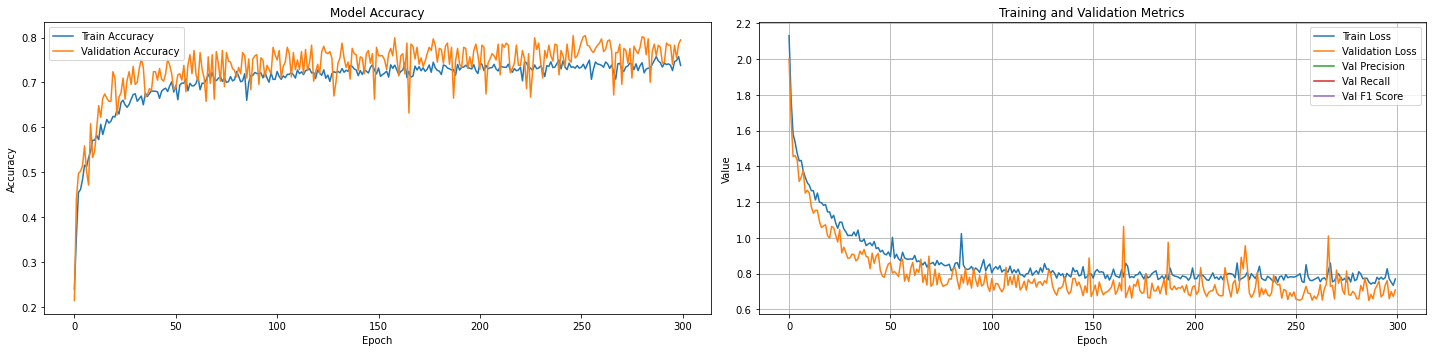

In [27]:
import matplotlib.pyplot as plt

# Plotting loss and accuracy curves
plt.figure(figsize=(20, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Precision, Recall, F1
plt.plot(history.history.get('val_precision', []), label='Val Precision')
plt.plot(history.history.get('val_recall', []), label='Val Recall')
plt.plot(history.history.get('val_f1', []), label='Val F1 Score')

plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
def get_img_array(img, size=(128, 128)):
    img = tf.image.resize(img, size)
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create model to map the last conv layer to output
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Record operations for gradient calculation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean intensity of the gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by its gradient importance
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize to 0–1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(original_img, heatmap, alpha=0.4):
    # Convert to 0–255 range for display
    original_img = np.array(original_img)
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the image
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.image.resize(
        np.expand_dims(jet_heatmap, 0),
        (original_img.shape[0], original_img.shape[1])
    ).numpy()[0]

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + original_img
    superimposed_img = np.uint8(255 * superimposed_img / np.max(superimposed_img))

    return superimposed_img

# Choose the last convolutional layer in your ConvNeXt model
last_conv_layer_name = None
for layer in reversed(ConvNeXt_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
if last_conv_layer_name is None:
    raise ValueError("No Conv2D layer found in model.")

print("Last conv layer for Grad-CAM:", last_conv_layer_name)

Last conv layer for Grad-CAM: conv2d_22


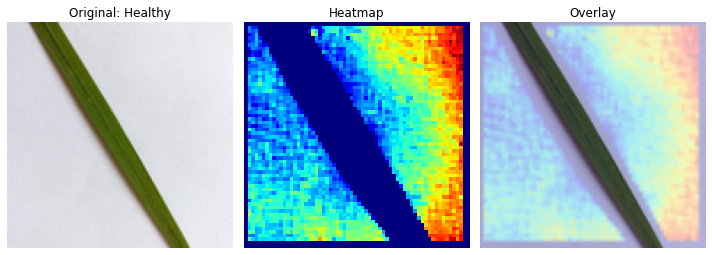

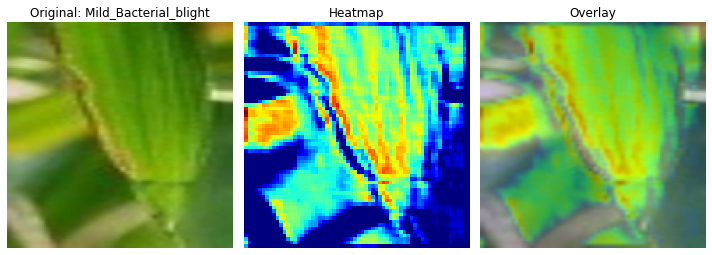

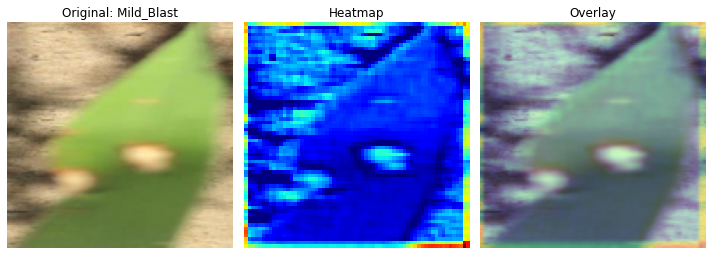

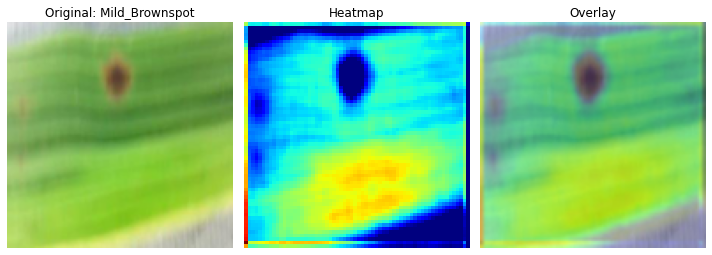

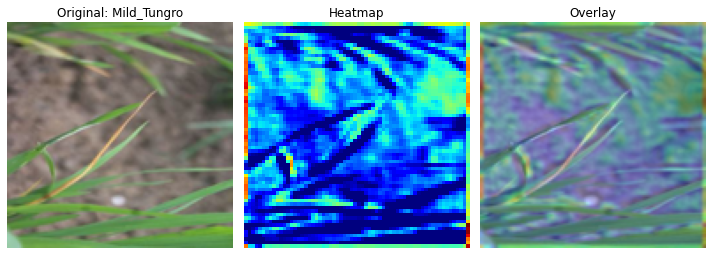

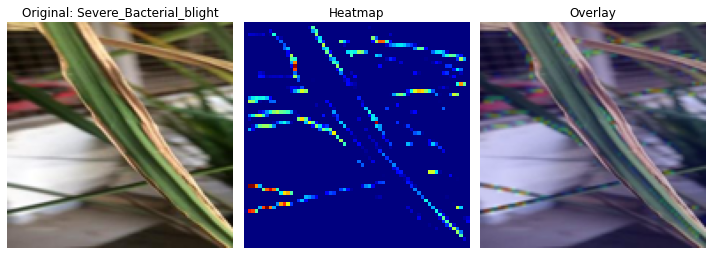

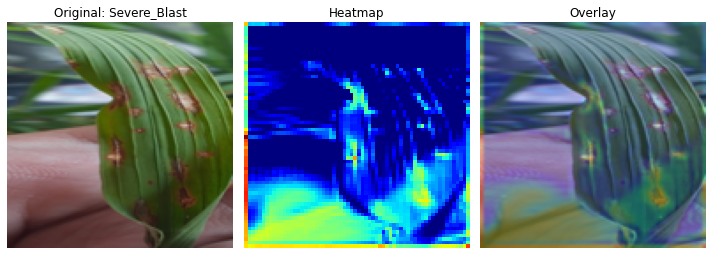

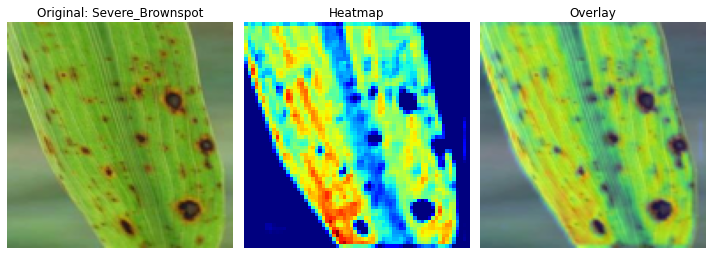

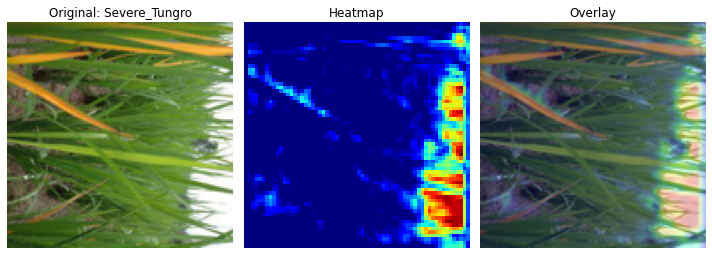

In [29]:
# For each class, pick one example from test set and visualize
for class_idx, class_name in enumerate(class_names):
    # Find an example from that class in x_test
    idx = np.where(y_test == class_idx)[0][0]
    original_img = x_test[idx]
    img_array = get_img_array(original_img)

    # Generate Grad-CAM heatmap for the target class
    heatmap = make_gradcam_heatmap(img_array, ConvNeXt_model, last_conv_layer_name, pred_index=class_idx)

    # Overlay heatmap
    overlay_img = display_gradcam(original_img, heatmap)

    # Plot: original, heatmap, overlay
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    ax[0].imshow(original_img)
    ax[0].set_title(f"Original: {class_name}")
    ax[0].axis("off")

    ax[1].imshow(heatmap, cmap="jet")
    ax[1].set_title("Heatmap")
    ax[1].axis("off")

    ax[2].imshow(overlay_img)
    ax[2].set_title("Overlay")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()


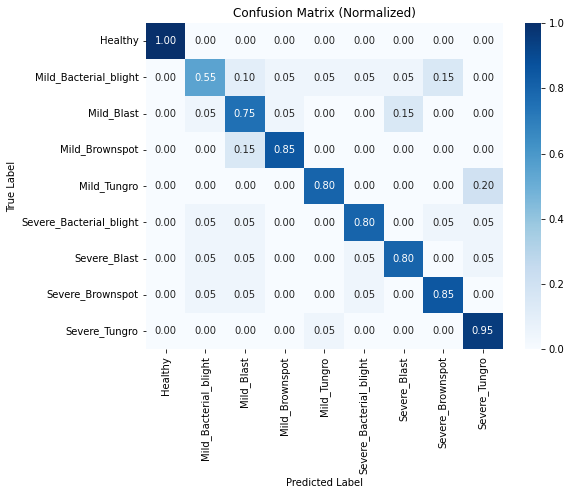

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions for test set
y_pred_probs = ConvNeXt_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize for percentages (optional)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Normalized)")
plt.show()


# References

* https://arxiv.org/abs/2201.03545

* https://github.com/facebookresearch/ConvNeXt

* https://arxiv.org/abs/1512.03385

* https://arxiv.org/abs/2103.14030

* https://arxiv.org/abs/1607.06450

* https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec

* https://paperswithcode.com/method/inverted-residual-block

* https://github.com/keras-team/keras/blob/master/keras/applications/convnext.py

* https://paperswithcode.com/method/gelu


# Citation
```bibtex
@Article{liu2022convnet,
  author  = {Zhuang Liu and Hanzi Mao and Chao-Yuan Wu and Christoph Feichtenhofer and Trevor Darrell and Saining Xie},
  title   = {A ConvNet for the 2020s},
  journal = {Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},
  year    = {2022},
}
```